# FullClass-TrainCNN(InceptionV3)_NoFreezModel_No-ClassImbalance

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
import numpy as np
from keras.applications.vgg16 import preprocess_input

## Training Set DIR

In [2]:
train_dataset_path='D:/DatasetMedicalWasteCropped/'

In [3]:
#train_dataset_path='D:/DatasetMedicalWasteCroppedBalanced/'

## Testing Set DIR

In [4]:
test_indoor_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/indoor'
test_outdoor_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/outdoor'
test_belt_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/belt'

In [5]:
img_height=299
img_width=299
batch_size=64

In [6]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dataset_path,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3868 files belonging to 41 classes.
Using 3095 files for training.


In [7]:
class_names = train_ds.class_names
class_number = len(class_names)
print(class_names)
print(f'number of class = {class_number}')

['1WayConnectorforFoley', '2WayConnectorforFoley', '2WayFoleyCatheter', '3WayConnectorforFoley', '3Waystopcock', 'AlcoholBottle', 'AlcoholPad', 'BootCover', 'CottonBall', 'CottonSwap', 'Dilator', 'DisposableInfusionSet', 'ExtensionTube', 'FaceShield', 'FrontLoadSyringe', 'GauzePad', 'Glove', 'GuideWire', 'LiquidBottle', 'Mask', 'NGTube', 'NasalCannula', 'Needle', 'OxygenMask', 'PPESuit', 'PharmaceuticalProduct', 'Pill', 'PillBottle', 'PrefilledHumidifier', 'PressureConnectingTube', 'ReusableHumidifier', 'SodiumChlorideBag', 'SterileHumidifierAdapter', 'SurgicalBlade', 'SurgicalCap', 'SurgicalSuit', 'Syringe', 'TrachealTube', 'UrineBag', 'Vaccinebottle', 'WingedInfusionSet']
number of class = 41


In [8]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  train_dataset_path,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3868 files belonging to 41 classes.
Using 773 files for validation.


In [9]:
test_indoor_ds = tf.keras.utils.image_dataset_from_directory(
  test_indoor_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1794 files belonging to 41 classes.


In [10]:
test_outdoor_ds = tf.keras.utils.image_dataset_from_directory(
  test_outdoor_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3140 files belonging to 41 classes.


In [11]:
test_belt_ds = tf.keras.utils.image_dataset_from_directory(
  test_belt_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2206 files belonging to 41 classes.


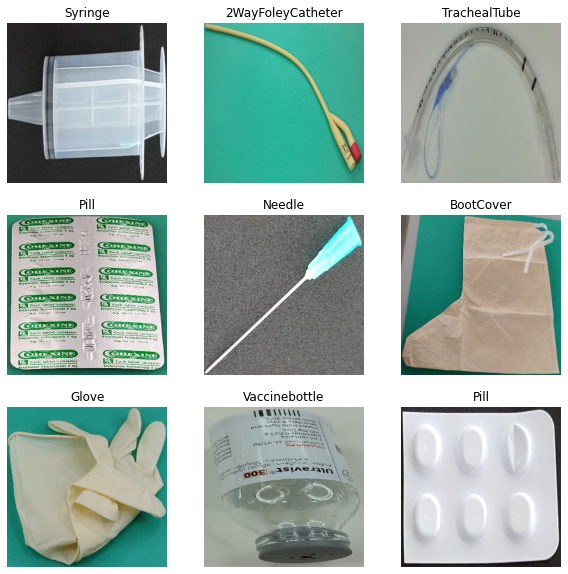

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [13]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(height_factor=0.1),
  layers.RandomContrast(0.05),
])

In [14]:
normalization_layer = layers.Rescaling(1./255)

#Apply the preprocessing layers to your dataset
AUTOTUNE = tf.data.AUTOTUNE
#train_ds = train_ds.cache().shuffle(2000).prefetch(buffer_size=AUTOTUNE)
#val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

def prepare(ds, shuffle=False, augment=False):
  # Normalize by 255 all datasets.
  ds = ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(2000)

  # Batch all datasets.
  #ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.cache().prefetch(buffer_size=AUTOTUNE)

In [15]:
train_ds = prepare(train_ds, shuffle=True, augment=False)
val_ds = prepare(val_ds)
test_indoor_ds = prepare(test_indoor_ds)
test_outdoor_ds = prepare(test_outdoor_ds)
test_belt_ds = prepare(test_belt_ds)

In [16]:
# Test -> Fetching Mini Batch
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(64, 299, 299, 3)
(64,)


In [17]:
'''
vgg16_model = keras.applications.vgg16.VGG16()
model = Sequential()

for layer in vgg16_model.layers[:-1]: # this is where I changed your code
    model.add(layer)    

# Freeze the layers 
for layer in model.layers:
    layer.trainable = False

# Add 'softmax' instead of earlier 'prediction' layer.
model.add(Dense(2, activation='softmax'))
'''
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.backend as K
import numpy as np
from tensorflow.keras.layers import Dense, Input, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3

inceptionv3_model = keras.applications.InceptionV3(input_shape=(img_height,img_width,3),include_top=True,weights="imagenet",classifier_activation="softmax")

inceptionv3_model_nooutput = inceptionv3_model.layers[-2].output
custom_inceptionv3_model = Model(inputs = inceptionv3_model.input, outputs = inceptionv3_model_nooutput)
print(custom_inceptionv3_model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [18]:
model = tf.keras.Sequential()
# Feature Extractor
model.add(custom_inceptionv3_model)
# Classifier
model.add(tf.keras.layers.Dense(len(class_names), activation='softmax'))
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [19]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 2048)              21802784  
_________________________________________________________________
dense (Dense)                (None, 41)                84009     
Total params: 21,886,793
Trainable params: 21,852,361
Non-trainable params: 34,432
_________________________________________________________________


In [20]:
EPOCHS = 2000
save_model_interval = 10
checkpoint_filepath = 'D:/ModelMedicalWasteCheckpoint/Incepv3_OurOutputLayer-NoClassImbalanced-NoAug-MediumSlowLR/OurOutputLayer-NoClassImbalanced-NoAug-epoch{epoch:04d}-val_acc{val_accuracy:.2f}.pb'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_freq='epoch',
    period=save_model_interval,
    save_best_only=False)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                  patience=5, min_lr=0.00001,cooldown=1, verbose=1)
# Model weights are saved at the end of every epoch, if it's the best seen
# so far.
history = model.fit(train_ds,validation_data=val_ds,epochs=EPOCHS, callbacks=[model_checkpoint_callback,reduce_lr])

Epoch 1/2000
49/49 [==============================] - 68s 740ms/step - loss: 1.0913 - accuracy: 0.7073 - val_loss: 4.0841 - val_accuracy: 0.1863
Epoch 2/2000
49/49 [==============================] - 28s 574ms/step - loss: 0.3490 - accuracy: 0.8840 - val_loss: 3.6556 - val_accuracy: 0.2199
Epoch 3/2000
49/49 [==============================] - 28s 574ms/step - loss: 0.1826 - accuracy: 0.9451 - val_loss: 5.3782 - val_accuracy: 0.4036
Epoch 4/2000
49/49 [==============================] - 28s 575ms/step - loss: 0.1421 - accuracy: 0.9554 - val_loss: 4.1240 - val_accuracy: 0.4683
Epoch 5/2000
49/49 [==============================] - 28s 575ms/step - loss: 0.1088 - accuracy: 0.9648 - val_loss: 0.7737 - val_accuracy: 0.8008
Epoch 6/2000
49/49 [==============================] - 28s 576ms/step - loss: 0.1148 - accuracy: 0.9674 - val_loss: 1.1419 - val_accuracy: 0.6999
Epoch 7/2000
49/49 [==============================] - 28s 576ms/step - loss: 0.0485 - accuracy: 0.9858 - val_loss: 0.7789 - val_ac

Text(0.5, 1.0, 'Training and Validation Accuracy')

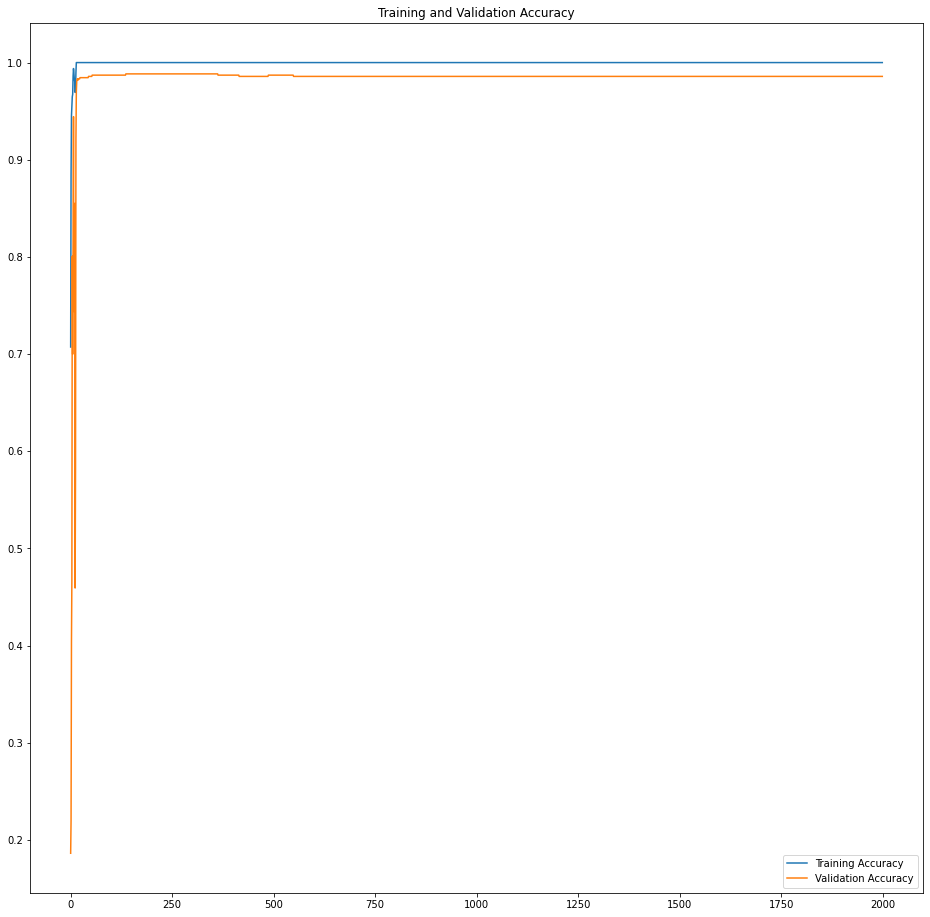

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(16, 16))
#plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


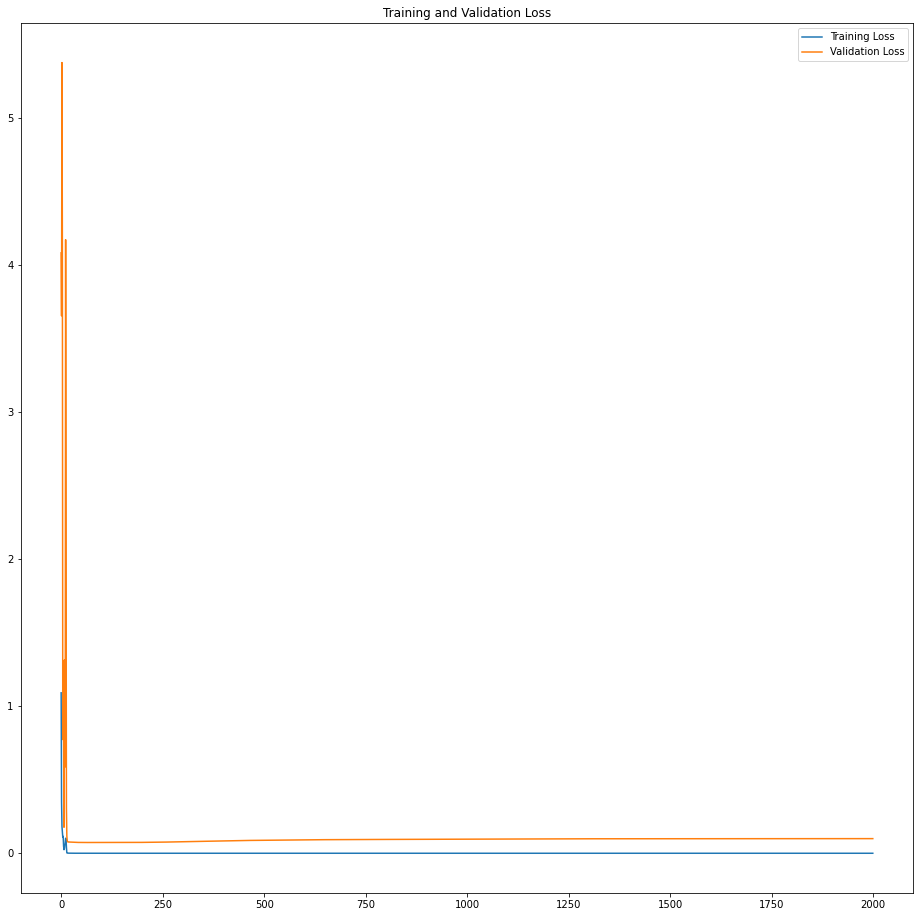

In [22]:
#plt.subplot(1, 2, 2)
plt.figure(figsize=(16, 16))
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [23]:
#indoor testset
test_indoor_ds_results = model.evaluate(test_indoor_ds)
print("test_indoor_ds_results:test loss, test acc:", test_indoor_ds_results)

29/29 [==============================] - 14s 350ms/step - loss: 4.9272 - accuracy: 0.5006
test_indoor_ds_results:test loss, test acc: [4.927197456359863, 0.5005574226379395]


In [24]:
#outdoor testset
test_outdoor_ds_results = model.evaluate(test_outdoor_ds)
print("test_outdoor_ds_results:test loss, test acc:", test_outdoor_ds_results)

50/50 [==============================] - 28s 463ms/step - loss: 2.6037 - accuracy: 0.6631
test_outdoor_ds_results:test loss, test acc: [2.603675127029419, 0.6630573272705078]


In [25]:
#belt testset
test_belt_ds_results = model.evaluate(test_belt_ds)
print("test_belt_ds_results:test loss, test acc:", test_belt_ds_results)

35/35 [==============================] - 8s 200ms/step - loss: 1.3542 - accuracy: 0.7693
test_belt_ds_results:test loss, test acc: [1.3541690111160278, 0.7692656517028809]


In [26]:
# Read path of trained model
import os, os.path
trained_path = 'D:/ModelMedicalWasteCheckpoint/Incepv3_OurOutputLayer-NoClassImbalanced-NoAug-MediumSlowLR/'
models_paths = []
for name_folder in os.listdir(trained_path):
    if os.path.isdir(os.path.join(trained_path, name_folder)):
        models_paths.append(os.path.join(trained_path, name_folder))
models_paths

['D:/ModelMedicalWasteCheckpoint/OurOutputLayer-NoClassImbalanced-NoAug-MediumSlowLR/OurOutputLayer-NoClassImbalanced-NoAug-epoch0010-val_acc0.81.pb',
 'D:/ModelMedicalWasteCheckpoint/OurOutputLayer-NoClassImbalanced-NoAug-MediumSlowLR/OurOutputLayer-NoClassImbalanced-NoAug-epoch0020-val_acc0.98.pb',
 'D:/ModelMedicalWasteCheckpoint/OurOutputLayer-NoClassImbalanced-NoAug-MediumSlowLR/OurOutputLayer-NoClassImbalanced-NoAug-epoch0030-val_acc0.98.pb',
 'D:/ModelMedicalWasteCheckpoint/OurOutputLayer-NoClassImbalanced-NoAug-MediumSlowLR/OurOutputLayer-NoClassImbalanced-NoAug-epoch0040-val_acc0.98.pb',
 'D:/ModelMedicalWasteCheckpoint/OurOutputLayer-NoClassImbalanced-NoAug-MediumSlowLR/OurOutputLayer-NoClassImbalanced-NoAug-epoch0050-val_acc0.99.pb',
 'D:/ModelMedicalWasteCheckpoint/OurOutputLayer-NoClassImbalanced-NoAug-MediumSlowLR/OurOutputLayer-NoClassImbalanced-NoAug-epoch0060-val_acc0.99.pb',
 'D:/ModelMedicalWasteCheckpoint/OurOutputLayer-NoClassImbalanced-NoAug-MediumSlowLR/OurOutput

In [27]:
test_indoor_acc = []
test_outdoor_acc = []
test_belt_acc = []
test_indoor_loss = []
test_outdoor_loss = []
test_belt_loss = []

for lm_idx,plmodel in enumerate(models_paths):
    loaded_model=tf.keras.models.load_model(plmodel)
    ## -> keep loss / acc in each epoch
    #indoor
    test_indoor_results = loaded_model.evaluate(test_indoor_ds)
    test_indoor_loss.append(test_indoor_results[0]) # append loss
    test_indoor_acc.append(test_indoor_results[1]) # append acc
    #outdoor
    test_outdoor_results = loaded_model.evaluate(test_outdoor_ds)
    test_outdoor_loss.append(test_outdoor_results[0]) # append loss
    test_outdoor_acc.append(test_outdoor_results[1]) # append acc
    #belt
    test_belt_results = loaded_model.evaluate(test_belt_ds)
    test_belt_loss.append(test_belt_results[0]) # append loss
    test_belt_acc.append(test_belt_results[1]) # append acc
    # printout
    lm_idx_show = (lm_idx+1) * save_model_interval
    print(f"Epoch{lm_idx_show:04d} \n test_indoor_acc={test_indoor_acc[lm_idx]} \n test_outdoor_acc={test_outdoor_acc[lm_idx]} \n test_belt_acc={test_belt_acc[lm_idx]}")

35/35 [==============================] - 5s 142ms/step - loss: 2.4654 - accuracy: 0.5136
Epoch0010 
 test_indoor_acc=0.31716832518577576 
 test_outdoor_acc=0.41783440113067627 
 test_belt_acc=0.5135992765426636
35/35 [==============================] - 5s 142ms/step - loss: 1.2145 - accuracy: 0.7212
Epoch0020 
 test_indoor_acc=0.4894091486930847 
 test_outdoor_acc=0.6136942505836487 
 test_belt_acc=0.7212148904800415
35/35 [==============================] - 5s 144ms/step - loss: 1.1855 - accuracy: 0.7298
Epoch0030 
 test_indoor_acc=0.49944257736206055 
 test_outdoor_acc=0.6203821897506714 
 test_belt_acc=0.7298277616500854
35/35 [==============================] - 5s 144ms/step - loss: 1.1790 - accuracy: 0.7362
Epoch0040 
 test_indoor_acc=0.5027870535850525 
 test_outdoor_acc=0.6248407363891602 
 test_belt_acc=0.7361740469932556
35/35 [==============================] - 5s 142ms/step - loss: 1.1771 - accuracy: 0.7407
Epoch0050 
 test_indoor_acc=0.5039018988609314 
 test_outdoor_acc=0.6289

range(10, 2010, 10)


Text(0.5, 1.0, 'Testing(EvaluationModel) Accuracy')

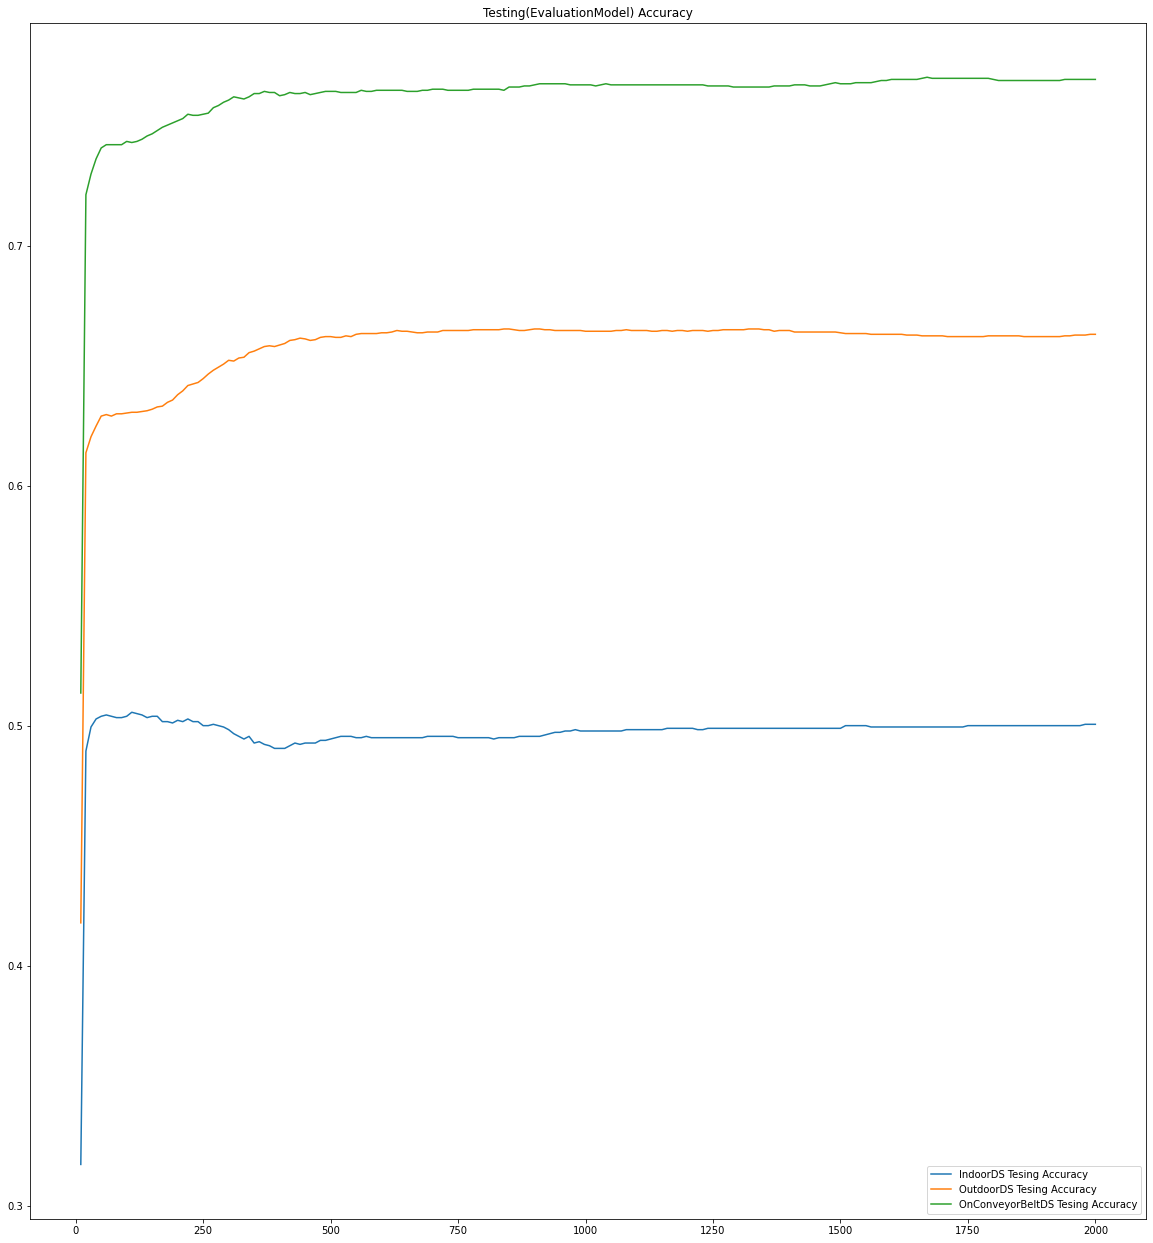

In [28]:
# loss / acc in each epoch graph ploting
#EPOCHS = 400
import matplotlib.pyplot as plt
epochs_range = range(save_model_interval,EPOCHS+save_model_interval,save_model_interval)
print(epochs_range)
plt.figure(figsize=(20, 22))
#plt.subplot(1, 2, 1)
plt.plot(epochs_range, test_indoor_acc, label='IndoorDS Tesing Accuracy')
plt.plot(epochs_range, test_outdoor_acc, label='OutdoorDS Tesing Accuracy')
plt.plot(epochs_range, test_belt_acc, label='OnConveyorBeltDS Tesing Accuracy')
plt.legend(loc='lower right')
plt.title('Testing(EvaluationModel) Accuracy')

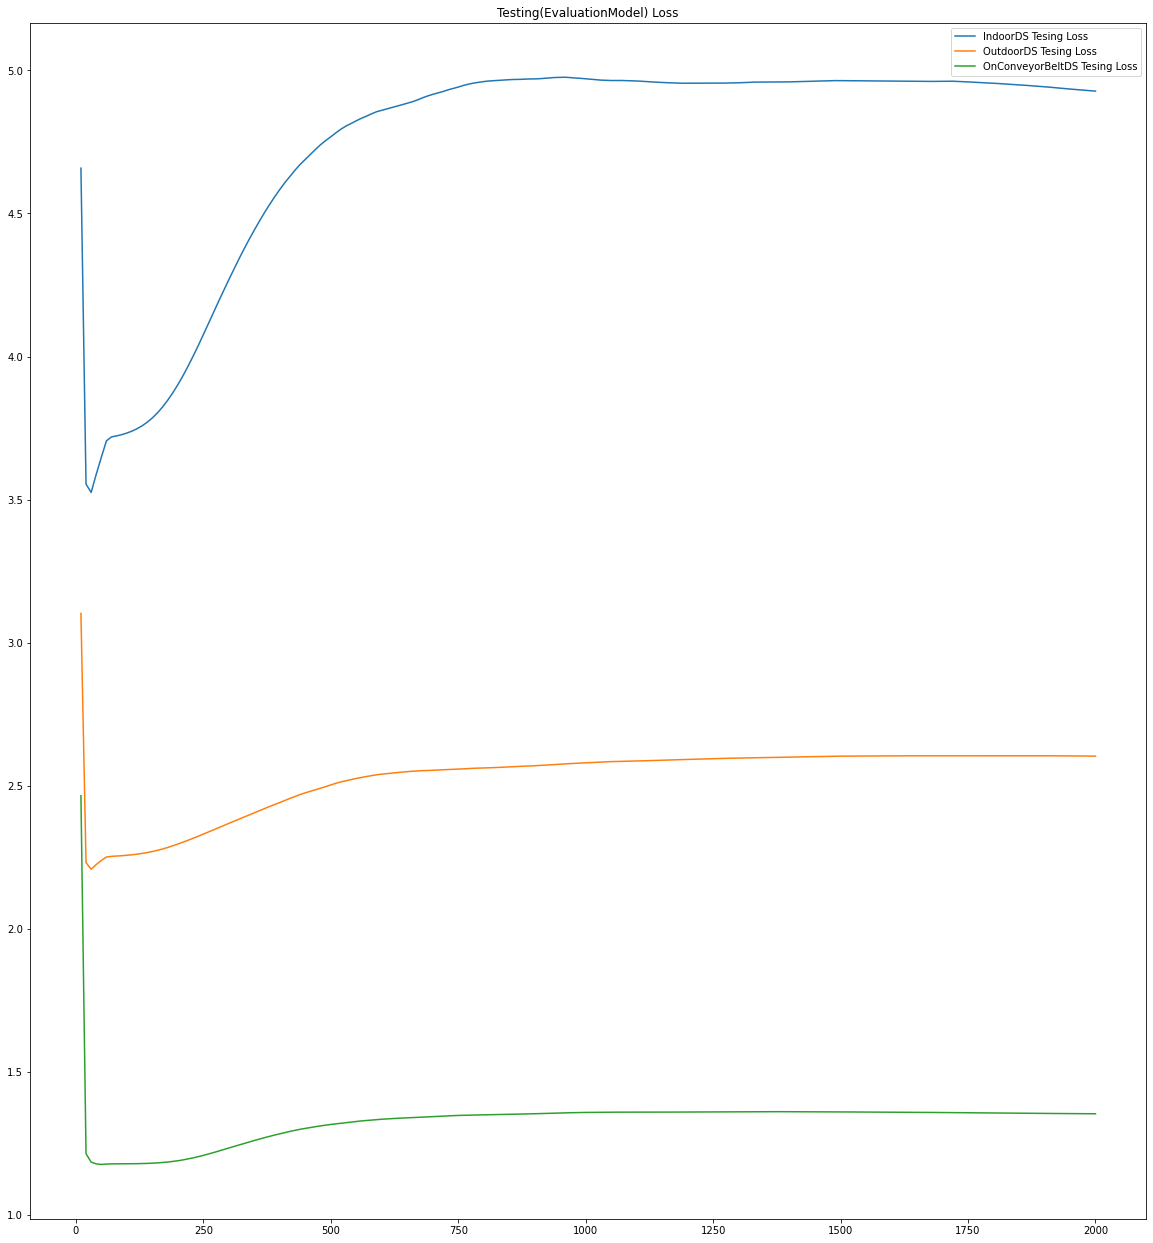

In [29]:
plt.figure(figsize=(20, 22))
#plt.subplot(1, 2, 2)
plt.plot(epochs_range, test_indoor_loss, label='IndoorDS Tesing Loss')
plt.plot(epochs_range, test_outdoor_loss, label='OutdoorDS Tesing Loss')
plt.plot(epochs_range, test_belt_loss, label='OnConveyorBeltDS Tesing Loss')
plt.legend(loc='upper right')
plt.title('Testing(EvaluationModel) Loss')
plt.show()

In [30]:
test_indoor_acc

[0.31716832518577576,
 0.4894091486930847,
 0.49944257736206055,
 0.5027870535850525,
 0.5039018988609314,
 0.5044593214988708,
 0.5039018988609314,
 0.5033444762229919,
 0.5033444762229919,
 0.5039018988609314,
 0.505574107170105,
 0.5050167441368103,
 0.5044593214988708,
 0.5033444762229919,
 0.5039018988609314,
 0.5039018988609314,
 0.5016722679138184,
 0.5016722679138184,
 0.5011148452758789,
 0.502229630947113,
 0.5016722679138184,
 0.5027870535850525,
 0.5016722679138184,
 0.5016722679138184,
 0.5,
 0.5,
 0.5005574226379395,
 0.5,
 0.49944257736206055,
 0.49832776188850403,
 0.49665552377700806,
 0.49554067850112915,
 0.49442586302757263,
 0.49554067850112915,
 0.49275362491607666,
 0.4933110475540161,
 0.4921962022781372,
 0.49163880944252014,
 0.49052396416664124,
 0.49052396416664124,
 0.49052396416664124,
 0.49163880944252014,
 0.49275362491607666,
 0.4921962022781372,
 0.49275362491607666,
 0.49275362491607666,
 0.49275362491607666,
 0.4938684403896332,
 0.4938684403896332,


In [31]:
test_outdoor_acc

[0.41783440113067627,
 0.6136942505836487,
 0.6203821897506714,
 0.6248407363891602,
 0.6289808750152588,
 0.6296178102493286,
 0.6289808750152588,
 0.6299362778663635,
 0.6299362778663635,
 0.6302548050880432,
 0.6305732727050781,
 0.6305732727050781,
 0.630891740322113,
 0.631210207939148,
 0.6318471431732178,
 0.6328025460243225,
 0.6331210136413574,
 0.634713351726532,
 0.6356688141822815,
 0.6378980875015259,
 0.6394904255867004,
 0.6417197585105896,
 0.6423566937446594,
 0.6429936289787292,
 0.6445859670639038,
 0.6464968323707581,
 0.6480891704559326,
 0.6493630409240723,
 0.6506369709968567,
 0.6522293090820312,
 0.6519108414649963,
 0.653184711933136,
 0.6535031795501709,
 0.6554139852523804,
 0.656050980091095,
 0.6570063829421997,
 0.6579617857933044,
 0.6582802534103394,
 0.6579617857933044,
 0.6585987210273743,
 0.6592356562614441,
 0.6605095267295837,
 0.6608280539512634,
 0.6614649891853333,
 0.6611465215682983,
 0.6605095267295837,
 0.6608280539512634,
 0.66178345680236

In [32]:
test_belt_acc

[0.5135992765426636,
 0.7212148904800415,
 0.7298277616500854,
 0.7361740469932556,
 0.7407071590423584,
 0.7420670986175537,
 0.7420670986175537,
 0.7420670986175537,
 0.7420670986175537,
 0.743427038192749,
 0.7429736852645874,
 0.743427038192749,
 0.7443336248397827,
 0.745693564414978,
 0.7466002106666565,
 0.747960090637207,
 0.7493200302124023,
 0.7502266764640808,
 0.7511332631111145,
 0.752039909362793,
 0.7529464960098267,
 0.7547597289085388,
 0.754306435585022,
 0.754306435585022,
 0.7547597289085388,
 0.7552130818367004,
 0.7574796080589294,
 0.7583861947059631,
 0.7597461342811584,
 0.7606527805328369,
 0.7620127201080322,
 0.7615593671798706,
 0.7611060738563538,
 0.7620127201080322,
 0.7633726000785828,
 0.7633726000785828,
 0.7642792463302612,
 0.7638259530067444,
 0.7638259530067444,
 0.7624660134315491,
 0.7629193067550659,
 0.7638259530067444,
 0.7633726000785828,
 0.7633726000785828,
 0.7638259530067444,
 0.7629193067550659,
 0.7633726000785828,
 0.7638259530067444,

In [33]:
test_indoor_loss

[4.658146381378174,
 3.554121494293213,
 3.5249881744384766,
 3.5883915424346924,
 3.647631883621216,
 3.705326557159424,
 3.719071388244629,
 3.7227060794830322,
 3.7269654273986816,
 3.732469320297241,
 3.7391860485076904,
 3.7476091384887695,
 3.7578413486480713,
 3.770279884338379,
 3.785233974456787,
 3.8028550148010254,
 3.8234307765960693,
 3.8466973304748535,
 3.8726911544799805,
 3.9012389183044434,
 3.9322500228881836,
 3.9655661582946777,
 4.000906944274902,
 4.0375800132751465,
 4.075804233551025,
 4.114742755889893,
 4.153829574584961,
 4.192506790161133,
 4.2305006980896,
 4.268084526062012,
 4.304851531982422,
 4.340915679931641,
 4.375791072845459,
 4.40926456451416,
 4.44146203994751,
 4.4726362228393555,
 4.5026984214782715,
 4.53079891204834,
 4.557971000671387,
 4.5833821296691895,
 4.607428073883057,
 4.629378795623779,
 4.651098728179932,
 4.671167373657227,
 4.688808441162109,
 4.706010818481445,
 4.7233805656433105,
 4.73996639251709,
 4.754359722137451,
 4.7674

In [34]:
test_outdoor_loss

[3.1024789810180664,
 2.231696844100952,
 2.208625316619873,
 2.2249553203582764,
 2.239439010620117,
 2.251182794570923,
 2.2536065578460693,
 2.2545745372772217,
 2.2557427883148193,
 2.2571873664855957,
 2.259005546569824,
 2.2611472606658936,
 2.2637367248535156,
 2.2668161392211914,
 2.2703917026519775,
 2.2745511531829834,
 2.2792060375213623,
 2.2844178676605225,
 2.290238618850708,
 2.2963907718658447,
 2.3028762340545654,
 2.309688091278076,
 2.3165857791900635,
 2.3237767219543457,
 2.331141233444214,
 2.338474750518799,
 2.3459510803222656,
 2.3535256385803223,
 2.3612465858459473,
 2.3687376976013184,
 2.376159191131592,
 2.3835196495056152,
 2.3907217979431152,
 2.3980040550231934,
 2.405564308166504,
 2.4128830432891846,
 2.4205431938171387,
 2.427750587463379,
 2.434573173522949,
 2.4415624141693115,
 2.4489858150482178,
 2.4560329914093018,
 2.4628541469573975,
 2.4694786071777344,
 2.475498914718628,
 2.4808974266052246,
 2.486638069152832,
 2.491574764251709,
 2.49706

In [35]:
test_belt_loss

[2.4653875827789307,
 1.214510202407837,
 1.185487151145935,
 1.179003357887268,
 1.1771196126937866,
 1.1784121990203857,
 1.1790571212768555,
 1.1791434288024902,
 1.1792263984680176,
 1.179373025894165,
 1.1795399188995361,
 1.1798079013824463,
 1.1802064180374146,
 1.1807231903076172,
 1.1815016269683838,
 1.1824997663497925,
 1.183797001838684,
 1.1854766607284546,
 1.1875331401824951,
 1.1899733543395996,
 1.1928987503051758,
 1.1962679624557495,
 1.2000131607055664,
 1.204174280166626,
 1.2086282968521118,
 1.2134380340576172,
 1.218475341796875,
 1.2237097024917603,
 1.2290488481521606,
 1.234391212463379,
 1.2397665977478027,
 1.2450618743896484,
 1.2503817081451416,
 1.2556182146072388,
 1.2606946229934692,
 1.2657030820846558,
 1.2705976963043213,
 1.2752922773361206,
 1.2798528671264648,
 1.284139633178711,
 1.2884254455566406,
 1.292525053024292,
 1.2963895797729492,
 1.3000000715255737,
 1.3031880855560303,
 1.3061131238937378,
 1.309100866317749,
 1.3119016885757446,
 1.

## Load Last Epoch and test in each class

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
import numpy as np
from keras.applications.vgg16 import preprocess_input

last_epoch_model = tf.keras.models.load_model('D:\ModelMedicalWasteCheckpoint\Incepv3_OurOutputLayer-NoClassImbalanced-NoAug-MediumSlowLR\OurOutputLayer-NoClassImbalanced-NoAug-epoch2000-val_acc0.99.pb')

test_indoor_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/indoor'
test_outdoor_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/outdoor'
test_belt_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/belt'

img_height=299
img_width=299
batch_size=64

test_indoor_ds = tf.keras.utils.image_dataset_from_directory(
  test_indoor_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_outdoor_ds = tf.keras.utils.image_dataset_from_directory(
  test_outdoor_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_belt_ds = tf.keras.utils.image_dataset_from_directory(
  test_belt_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

normalization_layer = layers.Rescaling(1./255)

data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(height_factor=0.1),
  layers.RandomContrast(0.05),
])

#Apply the preprocessing layers to your dataset
AUTOTUNE = tf.data.AUTOTUNE
#train_ds = train_ds.cache().shuffle(2000).prefetch(buffer_size=AUTOTUNE)
#val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

def prepare(ds, shuffle=False, augment=False):
  # Normalize by 255 all datasets.
  ds = ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(2000)

  # Batch all datasets.
  #ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.cache().prefetch(buffer_size=AUTOTUNE)

test_indoor_ds = prepare(test_indoor_ds)
test_outdoor_ds = prepare(test_outdoor_ds)
test_belt_ds = prepare(test_belt_ds)

class_names = ['1WayConnectorforFoley', '2WayConnectorforFoley', '2WayFoleyCatheter', '3WayConnectorforFoley', '3Waystopcock', 'AlcoholBottle', 'AlcoholPad', 'BootCover', 'CottonBall', 'CottonSwap', 'Dilator', 'DisposableInfusionSet', 'ExtensionTube', 'FaceShield', 'FrontLoadSyringe', 'GauzePad', 'Glove', 'GuideWire', 'LiquidBottle', 'Mask', 'NGTube', 'NasalCannula', 'Needle', 'OxygenMask', 'PPESuit', 'PharmaceuticalProduct', 'Pill', 'PillBottle', 'PrefilledHumidifier', 'PressureConnectingTube', 'ReusableHumidifier', 'SodiumChlorideBag', 'SterileHumidifierAdapter', 'SurgicalBlade', 'SurgicalCap', 'SurgicalSuit', 'Syringe', 'TrachealTube', 'UrineBag', 'Vaccinebottle', 'WingedInfusionSet']

x_test_indoor = np.concatenate([ x for x,y in test_indoor_ds],axis=0)
x_test_outdoor = np.concatenate([ x for x,y in test_outdoor_ds],axis=0)
x_test_belt = np.concatenate([ x for x,y in test_belt_ds],axis=0)
y_test_indoor = np.concatenate([ y for x,y in test_indoor_ds],axis=0)
y_test_outdoor = np.concatenate([ y for x,y in test_outdoor_ds],axis=0)
y_test_belt = np.concatenate([ y for x,y in test_belt_ds],axis=0)
print(f"train_indoor num x,y : {len(x_test_indoor)},{len(y_test_indoor)}")
print(f"train_outdoor num x,y : {len(x_test_outdoor)},{len(y_test_outdoor)}")
print(f"train_belt num x,y : {len(x_test_belt)},{len(y_test_belt)}")
x_all = np.concatenate([x_test_indoor,x_test_outdoor,x_test_belt],axis=0)
y_all = np.concatenate([y_test_indoor,y_test_outdoor,y_test_belt],axis=0)
print(f"all num x,y :{len(x_all)},{len(y_all)}")
# let's predict
y_all_predicted = last_epoch_model.predict(x_all,batch_size=128)

Found 1794 files belonging to 41 classes.
Found 3140 files belonging to 41 classes.
Found 2206 files belonging to 41 classes.
train_indoor num x,y : 1794,1794
train_outdoor num x,y : 3140,3140
train_belt num x,y : 2206,2206
all num x,y :7140,7140


In [2]:
y_all_predicted_max = np.array([],dtype=np.int)
# acc all
TP = 0
FP = 0
for i in range(len(y_all)):
    if(y_all[i]==np.argmax(y_all_predicted[i])):
        TP = TP + 1
    else :
        FP = FP + 1
    y_all_predicted_max=np.append(y_all_predicted_max,np.argmax(y_all_predicted[i]))
print(f'all={TP+FP}')
print(f'TP={TP}')
print(f'FP={FP}')
print(f'acc={TP/(TP+FP)}')

# acc eachclass
TP_eachclass = [0] * 41
FP_eachclass = [0] * 41
for i in range(len(y_all)):
    if(y_all[i]==np.argmax(y_all_predicted[i])):
        TP_eachclass[y_all[i]] = TP_eachclass[y_all[i]] + 1
    else :
        FP_eachclass[y_all[i]] = FP_eachclass[y_all[i]] + 1
#recheck
print(f'all check = {sum(TP_eachclass)+sum(FP_eachclass)}')

all=7140
TP=4677
FP=2463
acc=0.6550420168067227
all check = 7140


In [3]:
avg_acc_eachclass = []
for i in range(len(class_names)):
    print(f'{class_names[i]} acc = {TP_eachclass[i]/(TP_eachclass[i]+FP_eachclass[i])*100}%')
    avg_acc_eachclass.append(TP_eachclass[i]/(TP_eachclass[i]+FP_eachclass[i])*100)
all_avg_eachclass = sum(avg_acc_eachclass) / len(avg_acc_eachclass)
print(f'\n\n\nall_avg_eachclass = {all_avg_eachclass}%')


1WayConnectorforFoley acc = 76.72413793103449%
2WayConnectorforFoley acc = 78.91156462585033%
2WayFoleyCatheter acc = 51.49253731343284%
3WayConnectorforFoley acc = 84.61538461538461%
3Waystopcock acc = 96.3963963963964%
AlcoholBottle acc = 84.375%
AlcoholPad acc = 50.79365079365079%
BootCover acc = 60.24096385542169%
CottonBall acc = 85.02994011976048%
CottonSwap acc = 43.35664335664335%
Dilator acc = 79.48717948717949%
DisposableInfusionSet acc = 39.823008849557525%
ExtensionTube acc = 21.138211382113823%
FaceShield acc = 54.93827160493827%
FrontLoadSyringe acc = 16.8141592920354%
GauzePad acc = 39.20454545454545%
Glove acc = 78.86904761904762%
GuideWire acc = 16.964285714285715%
LiquidBottle acc = 51.526717557251914%
Mask acc = 93.24675324675324%
NGTube acc = 28.387096774193548%
NasalCannula acc = 45.13274336283185%
Needle acc = 87.14285714285714%
OxygenMask acc = 60.902255639097746%
PPESuit acc = 75.80645161290323%
PharmaceuticalProduct acc = 71.02803738317756%
Pill acc = 92.857142

In [5]:
# for plotting
import matplotlib.pyplot as plt
# for using scikit-learn's built-in metrics
from sklearn.metrics import *
# for using tesnorflow/keras' built-in metrics
import tensorflow.keras.backend as K
''' ndarray of shape (n_classes, n_classes)
Confusion matrix whose i-th row and j-th column entry indicates the number of samples with  {true label being i-th row class} and {predicted label being column j-th class}.
> Example
>>> y_true = ["cat", "ant", "cat", "cat", "ant", "bird"]
>>> y_pred = ["ant", "ant", "cat", "cat", "ant", "cat"]
>>> confusion_matrix(y_true, y_pred, labels=["ant", "bird", "cat"])
array([[2, 0, 0],
       [0, 0, 1],
       [1, 0, 2]])
พุดง่ายๆ แถวคือด้านความจริง
       หลักคือด้านที่ระบบทำนาย
'''
# 
confusionMat = confusion_matrix(y_all, y_all_predicted_max, labels=range(len(class_names)))
confusionMat

array([[ 89,   0,   1, ...,   0,   0,   0],
       [  8, 116,   1, ...,   0,   0,   0],
       [  0,   0,  69, ...,   0,   0,   5],
       ...,
       [  0,   0,   0, ...,  35,   8,   0],
       [  0,   0,   0, ...,   0, 135,   0],
       [  0,   0,   6, ...,   0,   1,  56]], dtype=int64)

In [6]:
confusionMatFloat = confusionMat.astype('float64')
confusionMatFloatPercent=confusionMatFloat/confusionMatFloat.sum(axis=1)[:,None]  # divided by number of sample in each class (sum of each row)
confusionMatFloatPercent*=100
confusionMatFloatPercent

array([[76.72413793,  0.        ,  0.86206897, ...,  0.        ,
         0.        ,  0.        ],
       [ 5.44217687, 78.91156463,  0.68027211, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        , 51.49253731, ...,  0.        ,
         0.        ,  3.73134328],
       ...,
       [ 0.        ,  0.        ,  0.        , ..., 29.16666667,
         6.66666667,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
        63.38028169,  0.        ],
       [ 0.        ,  0.        ,  5.26315789, ...,  0.        ,
         0.87719298, 49.12280702]])

<AxesSubplot:>

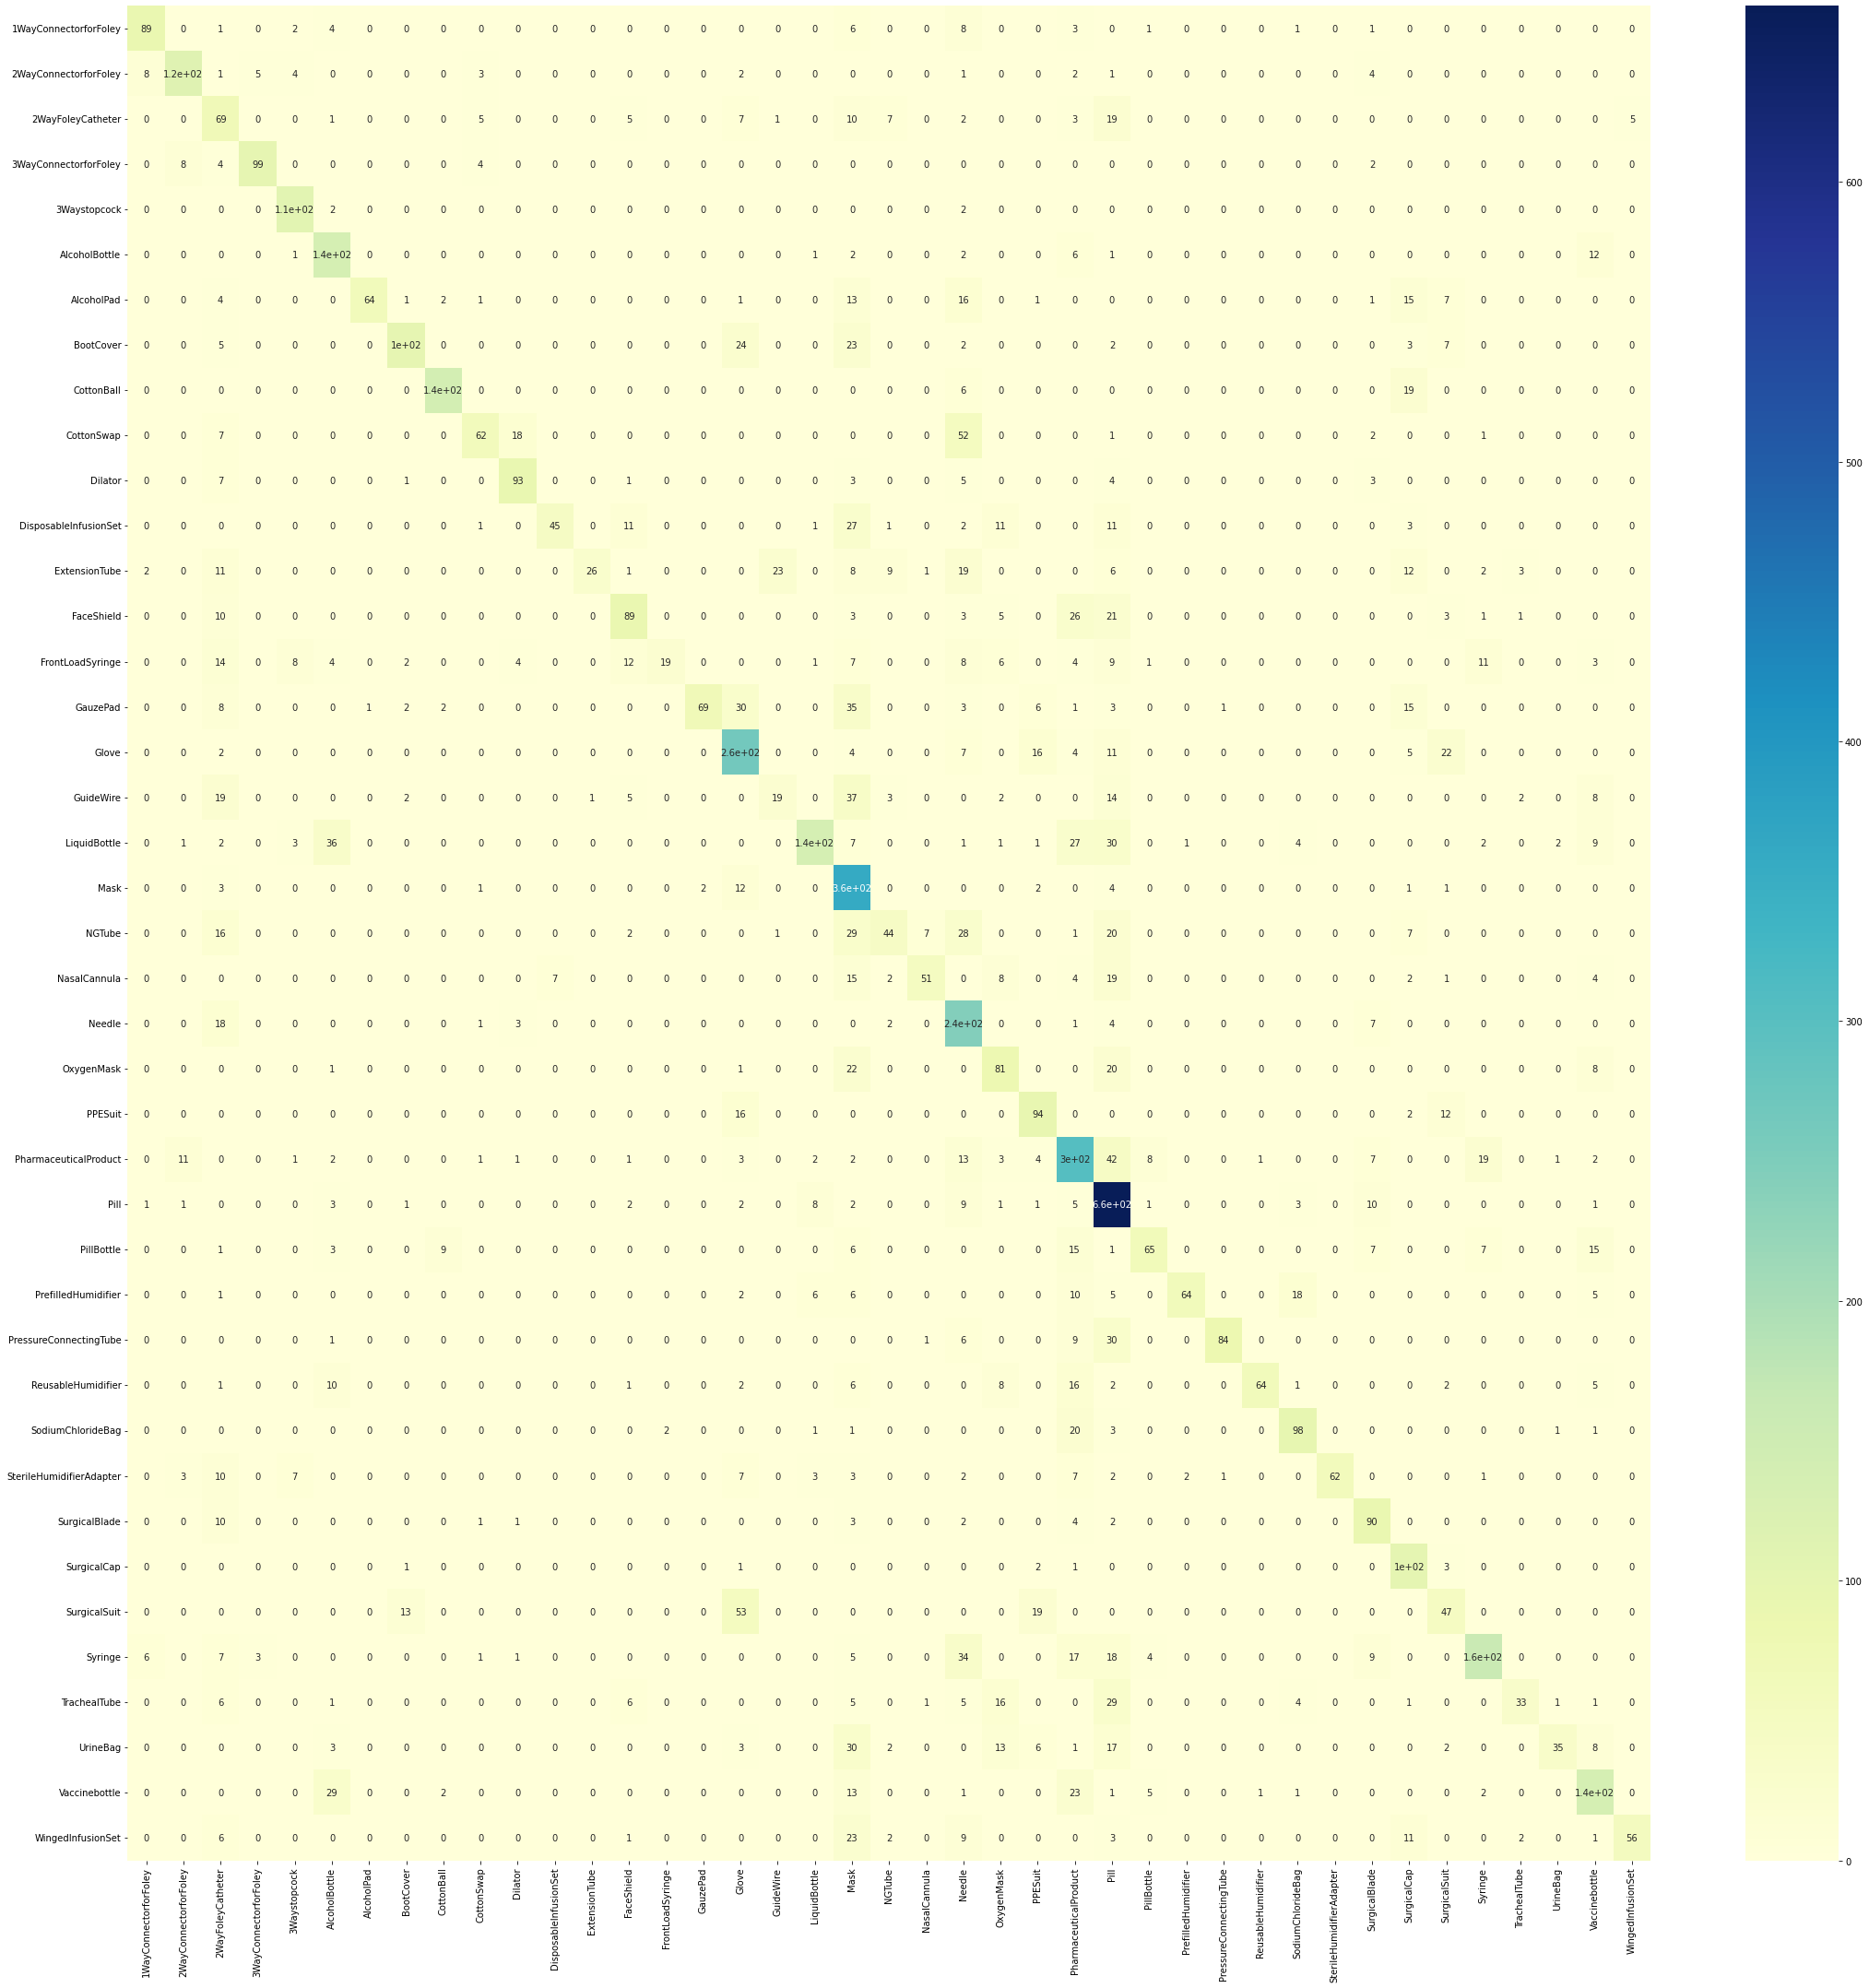

In [7]:
import seaborn as sn
import pandas as pd
df_cm = pd.DataFrame(confusionMat, index = class_names,
                  columns = class_names)
plt.figure(figsize = (37,37))
sn.heatmap(df_cm, annot=True,cmap="YlGnBu")

<AxesSubplot:>

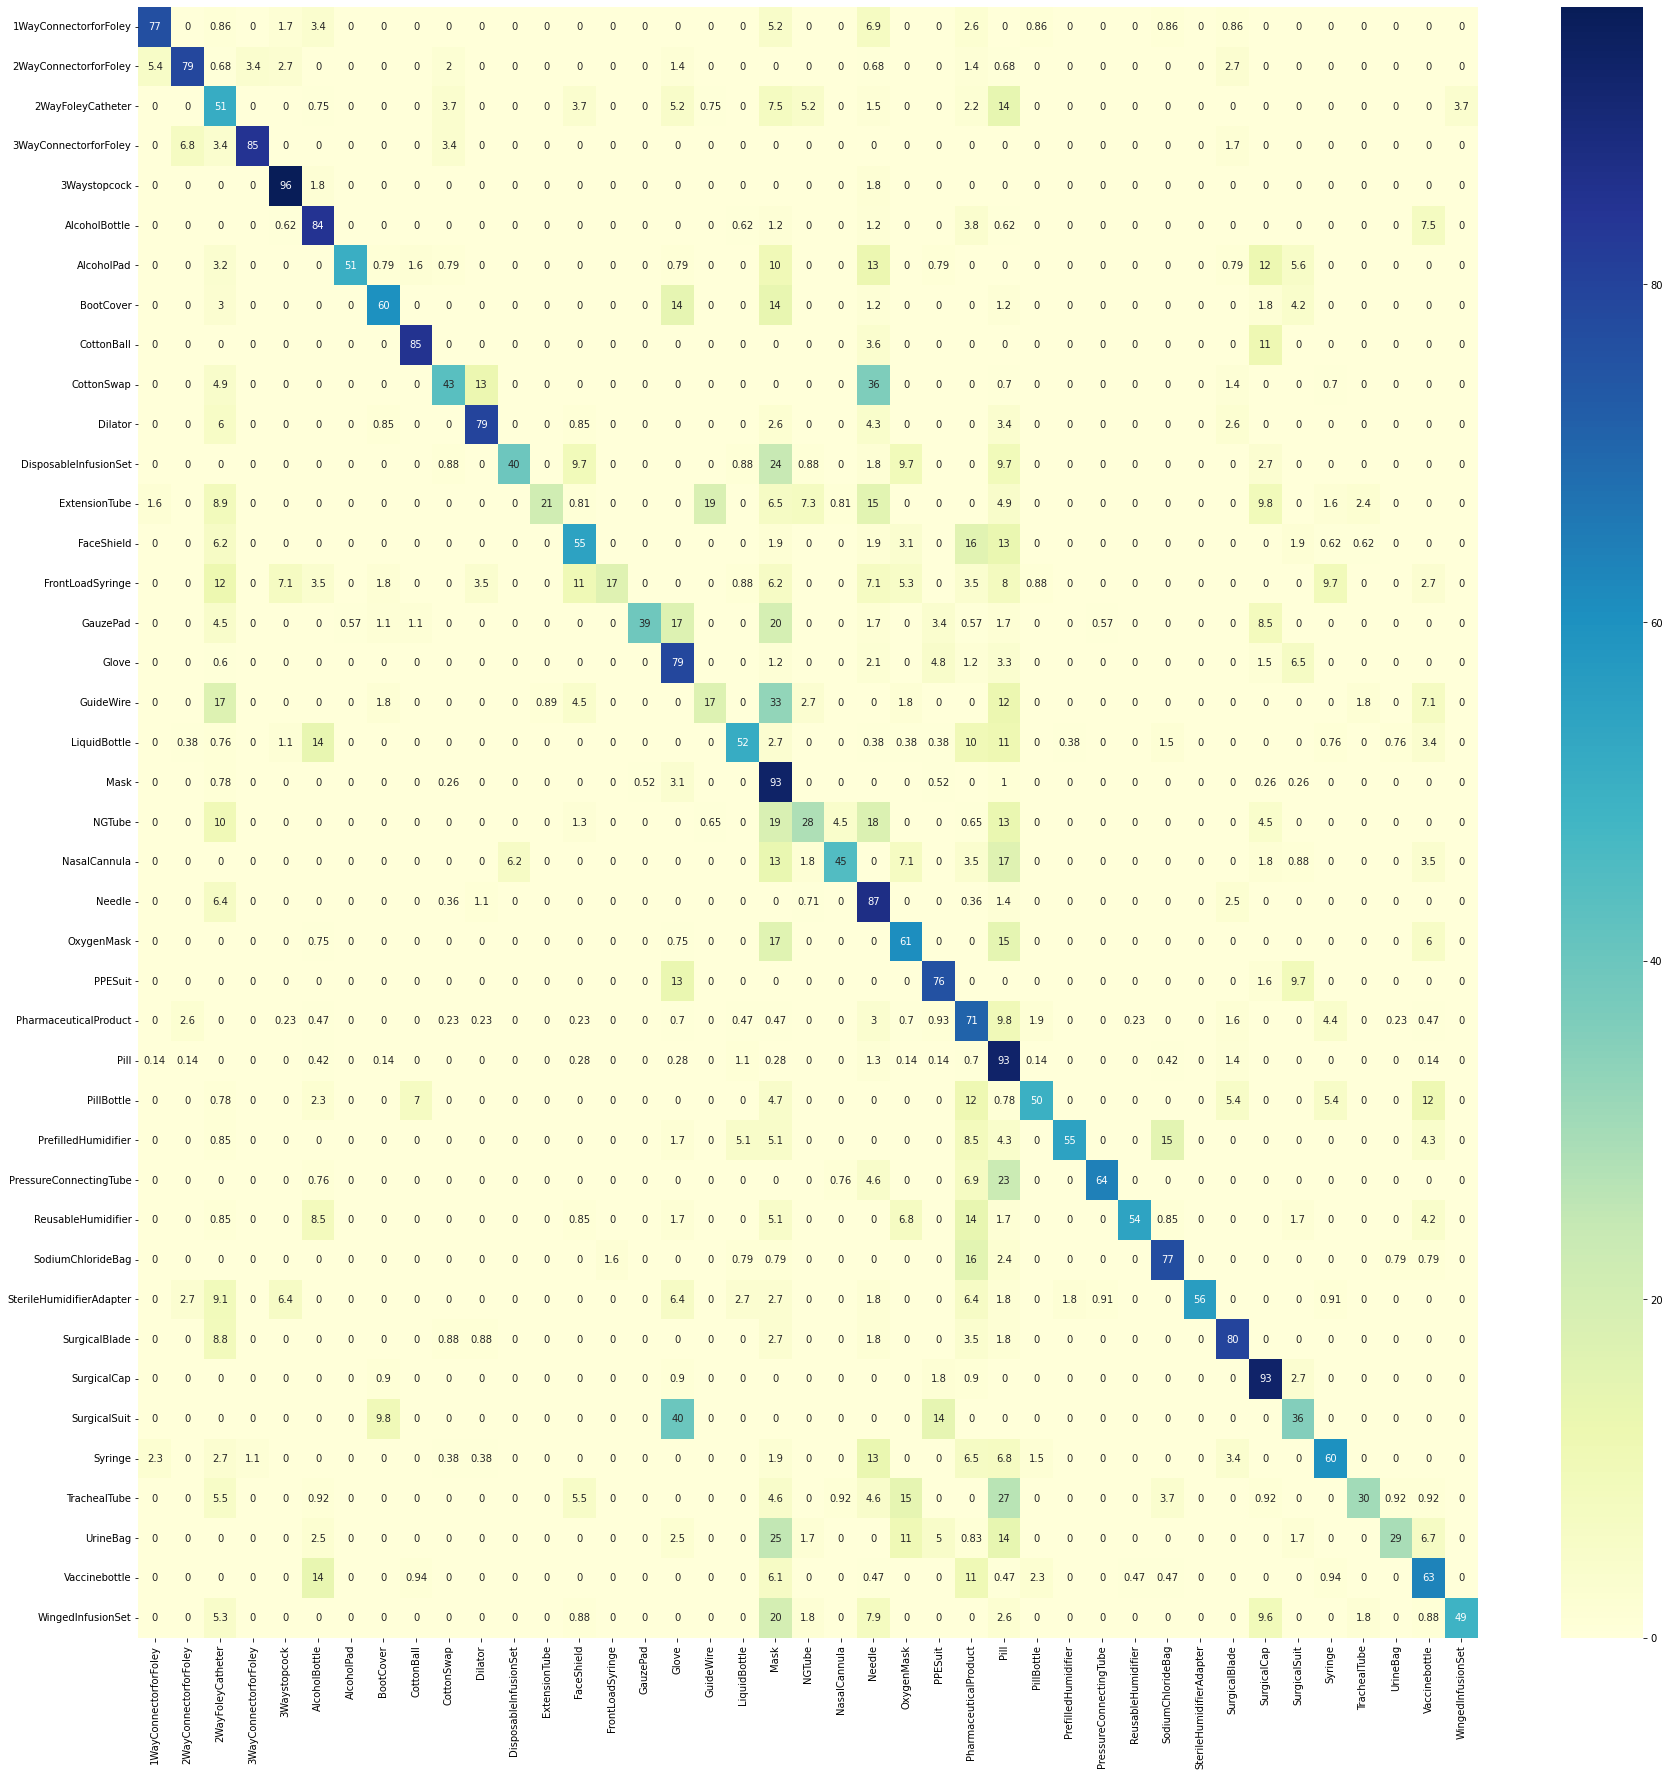

In [8]:
import seaborn as sn
import pandas as pd
df_cm = pd.DataFrame(confusionMatFloatPercent, index = class_names,
                  columns = class_names)
plt.figure(figsize = (30,30))
sn.heatmap(df_cm, annot=True,cmap="YlGnBu")

## Indoor -> YellowBG VS WoodBG

In [9]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
import numpy as np
from keras.applications.vgg16 import preprocess_input
# for plotting
import matplotlib.pyplot as plt
# for using scikit-learn's built-in metrics
from sklearn.metrics import *
# for using tesnorflow/keras' built-in metrics
import tensorflow.keras.backend as K
import seaborn as sn
import pandas as pd

last_epoch_model = tf.keras.models.load_model('D:\ModelMedicalWasteCheckpoint\OurOutputLayer-NoClassImbalanced-NoAug-MediumSlowLR\OurOutputLayer-NoClassImbalanced-NoAug-epoch2000-val_acc0.99.pb')

test_indoor_woodbg_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/indoor_woodbg/'
test_indoor_yellowbg_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/indoor_yellowbg/'

img_height=299
img_width=299
batch_size=64

test_indoor_woodbg_ds = tf.keras.utils.image_dataset_from_directory(
  test_indoor_woodbg_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_indoor_yellowbg_ds = tf.keras.utils.image_dataset_from_directory(
  test_indoor_yellowbg_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)



normalization_layer = layers.Rescaling(1./255)

data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(height_factor=0.1),
  layers.RandomContrast(0.05),
])

#Apply the preprocessing layers to your dataset
AUTOTUNE = tf.data.AUTOTUNE
#train_ds = train_ds.cache().shuffle(2000).prefetch(buffer_size=AUTOTUNE)
#val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

def prepare(ds, shuffle=False, augment=False):
  # Normalize by 255 all datasets.
  ds = ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(2000)

  # Batch all datasets.
  #ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.cache().prefetch(buffer_size=AUTOTUNE)

test_indoor_woodbg_ds = prepare(test_indoor_woodbg_ds)
test_indoor_yellowbg_ds = prepare(test_indoor_yellowbg_ds)


class_names = ['1WayConnectorforFoley', '2WayConnectorforFoley', '2WayFoleyCatheter', '3WayConnectorforFoley', '3Waystopcock', 'AlcoholBottle', 'AlcoholPad', 'BootCover', 'CottonBall', 'CottonSwap', 'Dilator', 'DisposableInfusionSet', 'ExtensionTube', 'FaceShield', 'FrontLoadSyringe', 'GauzePad', 'Glove', 'GuideWire', 'LiquidBottle', 'Mask', 'NGTube', 'NasalCannula', 'Needle', 'OxygenMask', 'PPESuit', 'PharmaceuticalProduct', 'Pill', 'PillBottle', 'PrefilledHumidifier', 'PressureConnectingTube', 'ReusableHumidifier', 'SodiumChlorideBag', 'SterileHumidifierAdapter', 'SurgicalBlade', 'SurgicalCap', 'SurgicalSuit', 'Syringe', 'TrachealTube', 'UrineBag', 'Vaccinebottle', 'WingedInfusionSet']

x_test_indoor_woodbg = np.concatenate([ x for x,y in test_indoor_woodbg_ds],axis=0)
x_test_indoor_yellowbg = np.concatenate([ x for x,y in test_indoor_yellowbg_ds],axis=0)

y_test_indoor_woodbg = np.concatenate([ y for x,y in test_indoor_woodbg_ds],axis=0)
y_test_indoor_yellowbg = np.concatenate([ y for x,y in test_indoor_yellowbg_ds],axis=0)

print(f"test_indoor_woodbg num x,y : {len(x_test_indoor_woodbg)},{len(y_test_indoor_woodbg)}")
print(f"test_indoor_yellowbg num x,y : {len(x_test_indoor_yellowbg)},{len(y_test_indoor_yellowbg)}")

# let's predict
y_woodbg_predicted = last_epoch_model.predict(x_test_indoor_woodbg,batch_size=128)
y_yellowbg_predicted = last_epoch_model.predict(x_test_indoor_yellowbg,batch_size=128)

Found 968 files belonging to 41 classes.
Found 916 files belonging to 41 classes.
test_indoor_woodbg num x,y : 968,968
test_indoor_yellowbg num x,y : 916,916


In [19]:
def getResults(y_target,y_predicted,verbose=True):
    y_predicted_max = np.array([],dtype=np.int)
    # acc all
    TP = 0
    FP = 0
    for i in range(len(y_predicted)):
        if(y_target[i]==np.argmax(y_predicted[i])):
            TP = TP + 1
        else :
            FP = FP + 1
        y_predicted_max=np.append(y_predicted_max,np.argmax(y_predicted[i]))
    acc = TP/(TP+FP)
    if verbose:
        print(f'all={TP+FP}')
        print(f'TP={TP}')
        print(f'FP={FP}')
        print(f'acc={acc}')

    # acc eachclass
    TP_eachclass = [0] * 41
    FP_eachclass = [0] * 41
    for i in range(len(y_target)):
        if(y_target[i]==np.argmax(y_predicted[i])):
            TP_eachclass[y_target[i]] = TP_eachclass[y_target[i]] + 1
        else :
            FP_eachclass[y_target[i]] = FP_eachclass[y_target[i]] + 1
    #recheck
    if verbose:
        print(f'all check = {sum(TP_eachclass)+sum(FP_eachclass)}')

    avg_acc_eachclass = []
    for i in range(len(class_names)):
        print(f'{class_names[i]} acc = {TP_eachclass[i]/(TP_eachclass[i]+FP_eachclass[i])*100}%')
        avg_acc_eachclass.append(TP_eachclass[i]/(TP_eachclass[i]+FP_eachclass[i])*100)
    all_avg_eachclass = sum(avg_acc_eachclass) / len(avg_acc_eachclass)
    if verbose:
        print(f'\n\n\nall_avg_eachclass = {all_avg_eachclass}%')
    
    confusionMat = confusion_matrix(y_target, y_predicted_max, labels=range(len(class_names)))

    if verbose:
        print(confusionMat)
    
    confusionMatFloat = confusionMat.astype('float64')
    confusionMatFloatPercent=confusionMatFloat/confusionMatFloat.sum(axis=1)[:,None]  # divided by number of sample in each class (sum of each row)
    confusionMatFloatPercent*=100


    return TP,FP,acc,TP_eachclass,FP_eachclass,avg_acc_eachclass,all_avg_eachclass,confusionMat,confusionMatFloatPercent



In [20]:
TP_wood,FP_wood,acc_wood,TP_eachclass_wood,FP_eachclass_wood,avg_acc_eachclass_wood,all_avg_eachclass_wood,confusionMat_wood,confusionMatFloatPercent_wood = getResults(y_test_indoor_woodbg,y_woodbg_predicted)

all=968
TP=616
FP=352
acc=0.6363636363636364
all check = 968
1WayConnectorforFoley acc = 36.84210526315789%
2WayConnectorforFoley acc = 76.92307692307693%
2WayFoleyCatheter acc = 58.333333333333336%
3WayConnectorforFoley acc = 100.0%
3Waystopcock acc = 93.75%
AlcoholBottle acc = 94.73684210526315%
AlcoholPad acc = 65.0%
BootCover acc = 50.0%
CottonBall acc = 80.0%
CottonSwap acc = 22.22222222222222%
Dilator acc = 95.0%
DisposableInfusionSet acc = 68.42105263157895%
ExtensionTube acc = 25.0%
FaceShield acc = 91.66666666666666%
FrontLoadSyringe acc = 16.666666666666664%
GauzePad acc = 30.0%
Glove acc = 97.05882352941177%
GuideWire acc = 55.00000000000001%
LiquidBottle acc = 66.66666666666666%
Mask acc = 96.42857142857143%
NGTube acc = 44.0%
NasalCannula acc = 65.21739130434783%
Needle acc = 85.71428571428571%
OxygenMask acc = 82.6086956521739%
PPESuit acc = 88.09523809523809%
PharmaceuticalProduct acc = 87.2340425531915%
Pill acc = 84.21052631578947%
PillBottle acc = 66.66666666666666%
P

In [21]:
TP_yellow,FP_yellow,acc_yellow,TP_eachclass_yellow,FP_eachclass_yellow,avg_acc_eachclass_yellow,all_avg_eachclass_yellow,confusionMat_yellow,confusionMatFloatPercent_yellow = getResults(y_test_indoor_yellowbg,y_yellowbg_predicted)

all=916
TP=331
FP=585
acc=0.361353711790393
all check = 916
1WayConnectorforFoley acc = 37.5%
2WayConnectorforFoley acc = 33.33333333333333%
2WayFoleyCatheter acc = 91.66666666666666%
3WayConnectorforFoley acc = 83.33333333333334%
3Waystopcock acc = 93.75%
AlcoholBottle acc = 65.0%
AlcoholPad acc = 35.0%
BootCover acc = 70.0%
CottonBall acc = 100.0%
CottonSwap acc = 16.666666666666664%
Dilator acc = 61.111111111111114%
DisposableInfusionSet acc = 0.0%
ExtensionTube acc = 0.0%
FaceShield acc = 0.0%
FrontLoadSyringe acc = 0.0%
GauzePad acc = 0.0%
Glove acc = 75.0%
GuideWire acc = 0.0%
LiquidBottle acc = 8.333333333333332%
Mask acc = 87.5%
NGTube acc = 0.0%
NasalCannula acc = 0.0%
Needle acc = 13.636363636363635%
OxygenMask acc = 0.0%
PPESuit acc = 88.09523809523809%
PharmaceuticalProduct acc = 95.83333333333334%
Pill acc = 68.18181818181817%
PillBottle acc = 61.111111111111114%
PrefilledHumidifier acc = 33.33333333333333%
PressureConnectingTube acc = 43.75%
ReusableHumidifier acc = 0.0%


<AxesSubplot:>

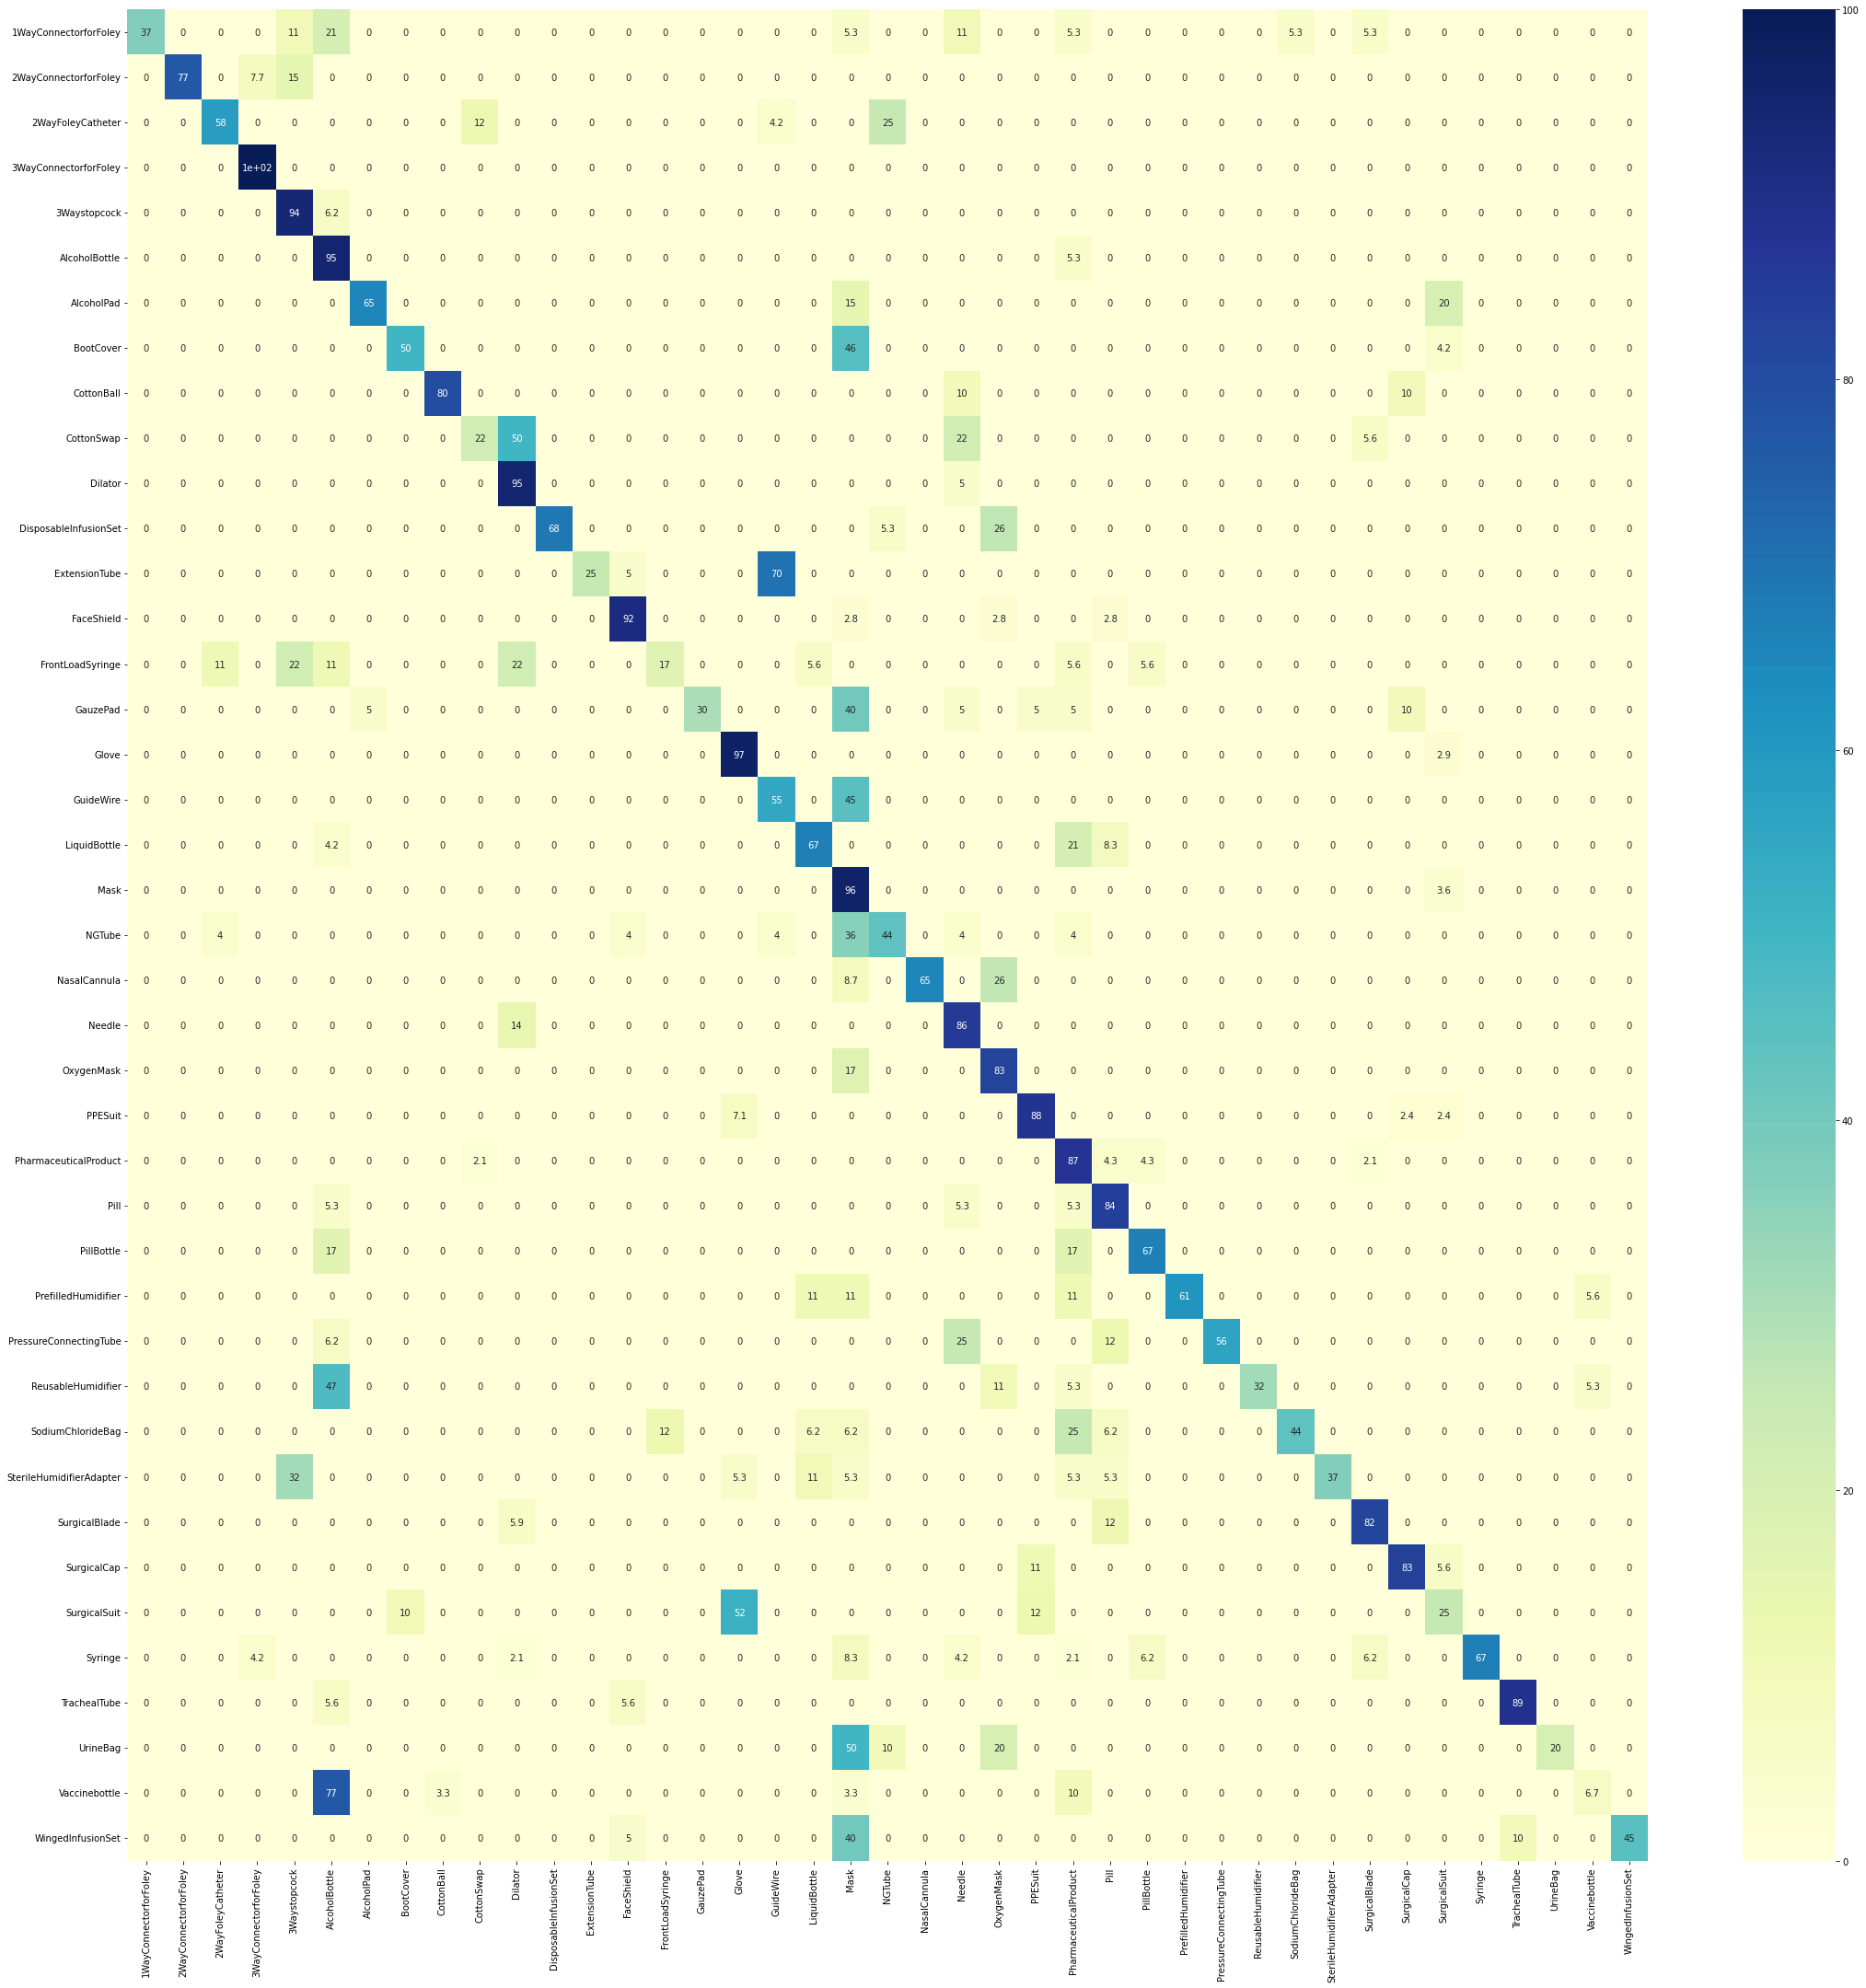

In [23]:
df_cm_wood = pd.DataFrame(confusionMatFloatPercent_wood, index = class_names,
                  columns = class_names)
plt.figure(figsize = (37,37))
sn.heatmap(df_cm_wood, annot=True,cmap="YlGnBu")

<AxesSubplot:>

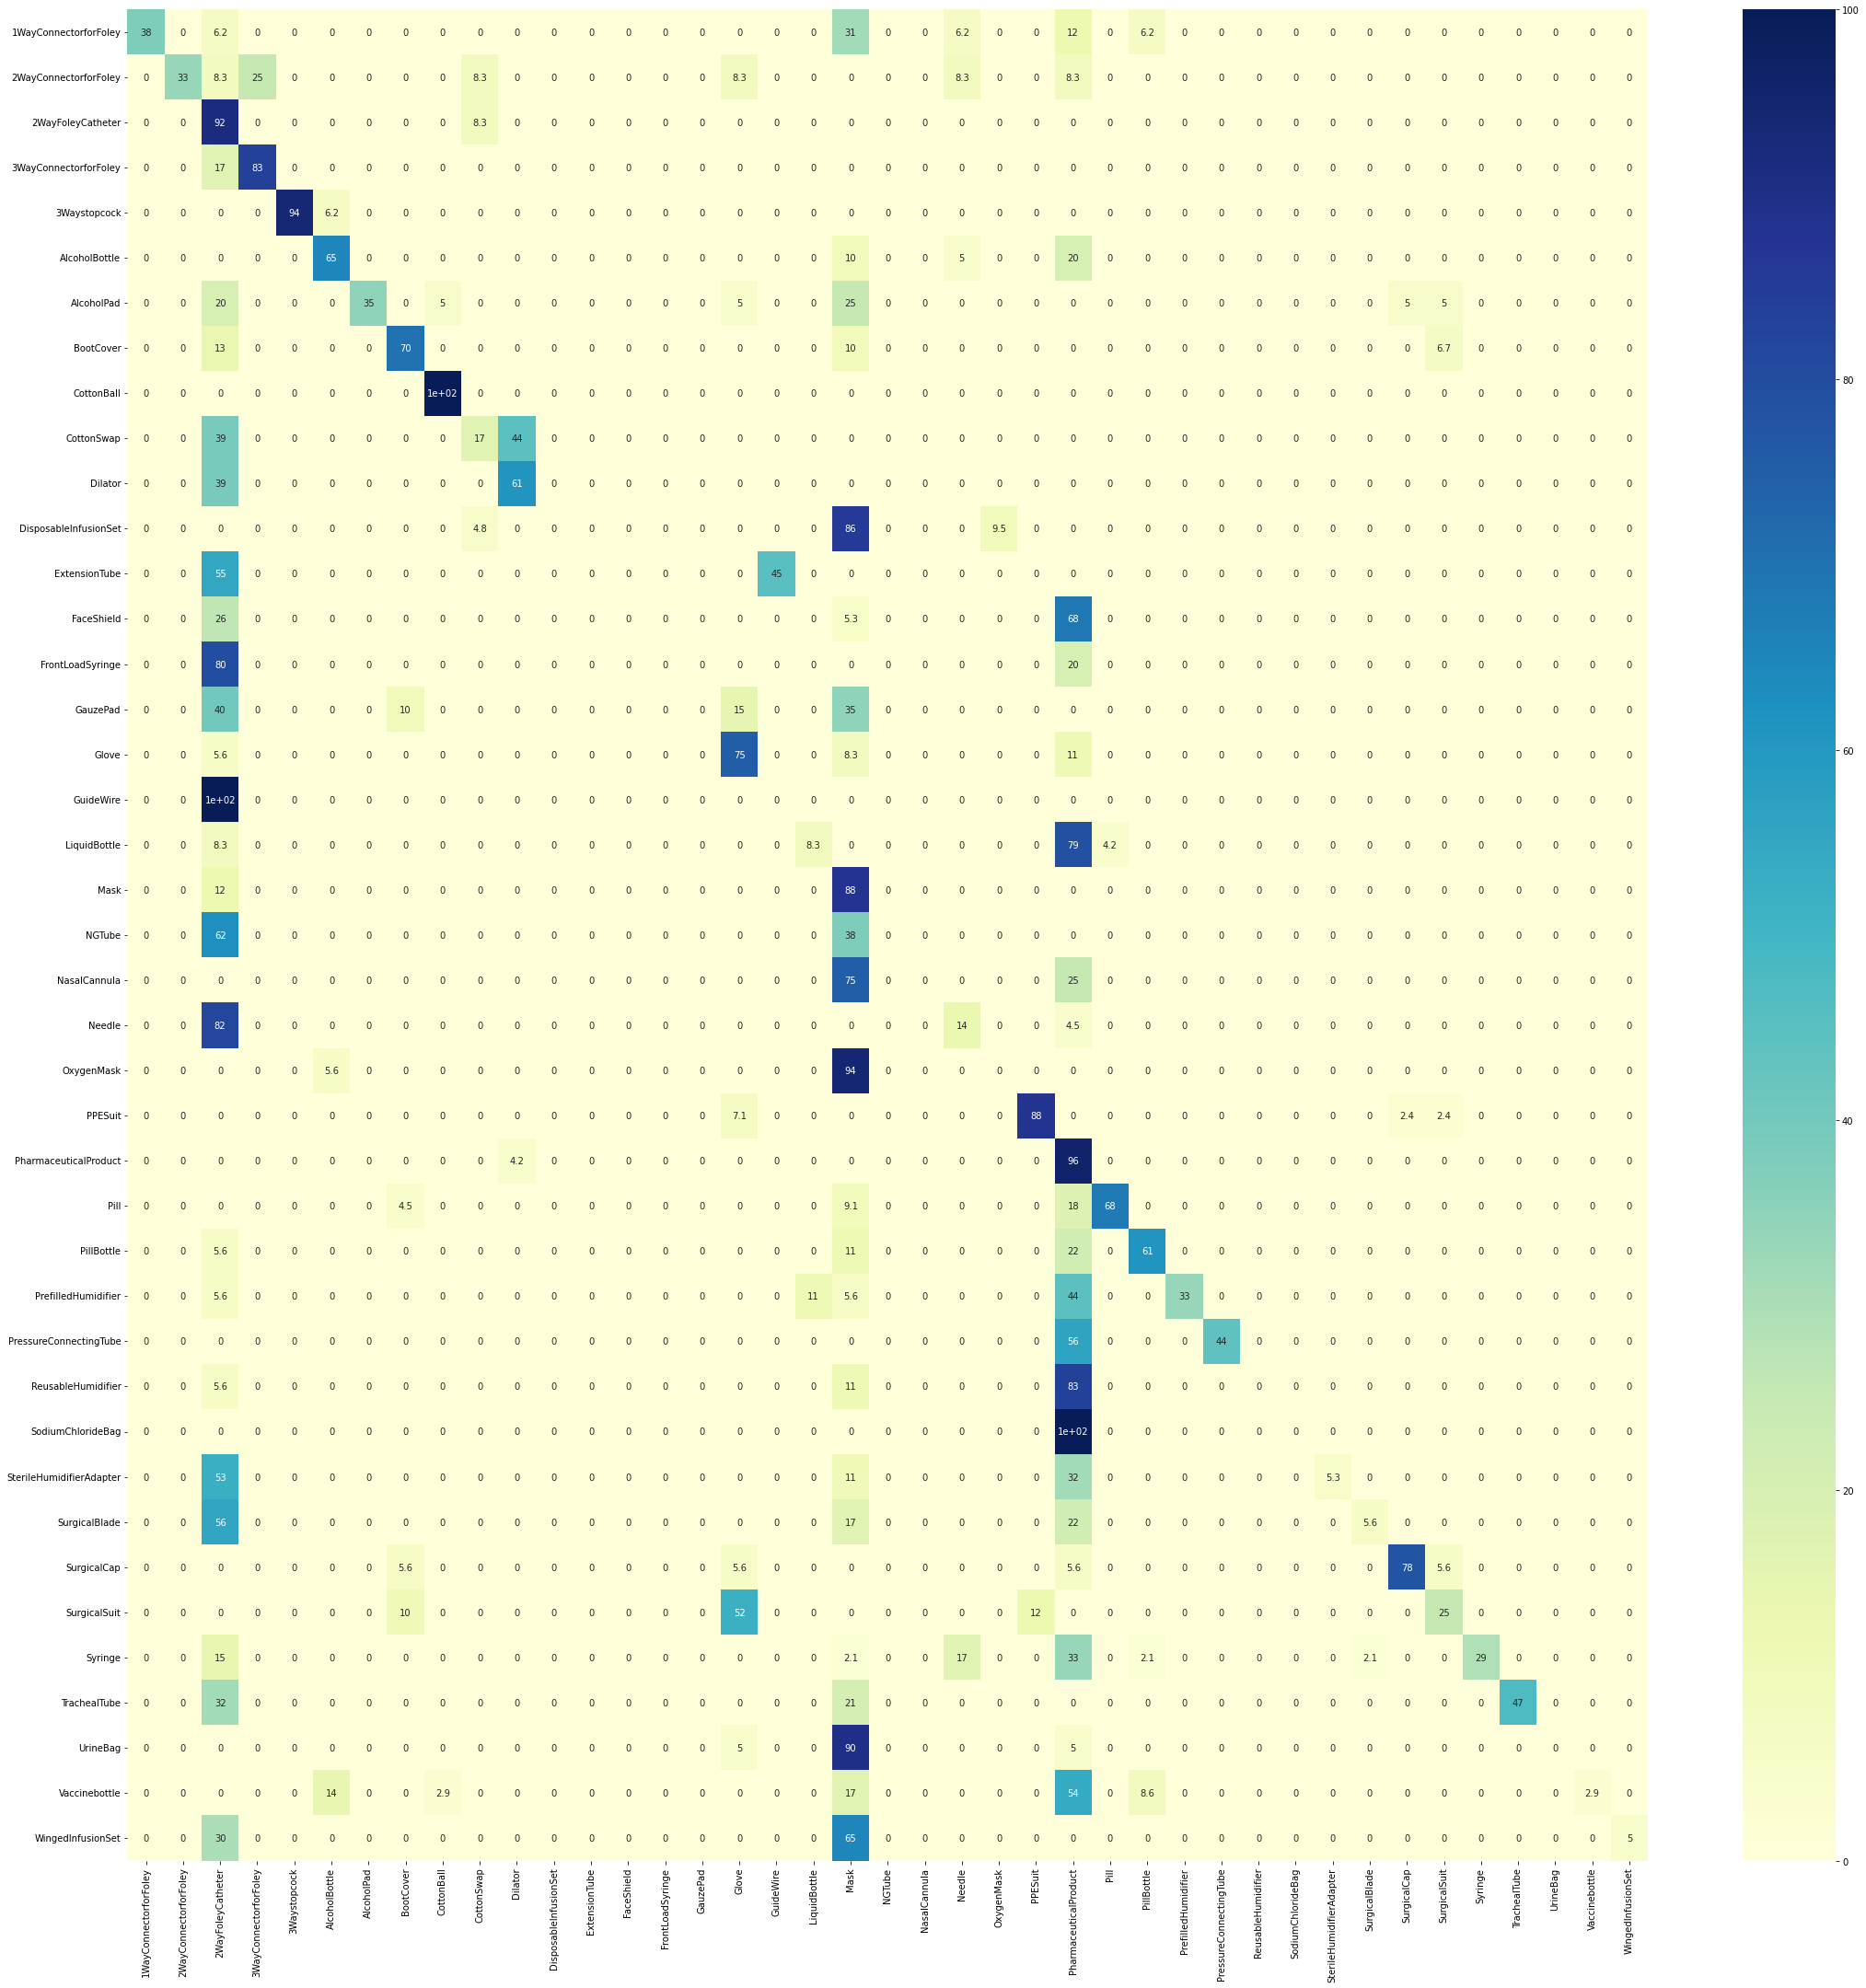

In [24]:
df_cm_yellow = pd.DataFrame(confusionMatFloatPercent_yellow, index = class_names,
                  columns = class_names)
plt.figure(figsize = (37,37))
sn.heatmap(df_cm_yellow, annot=True,cmap="YlGnBu")